# Plot profiles of mean quantities from various simulations for comparisons

In [1]:
%matplotlib inline
# import functions from python directory
import sys
sys.path.append("/home/bgreene/SBL_LES/python/")
import os
import seaborn
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MultipleLocator
from LESnc import load_stats, load_full

In [2]:
# plotting setup
rc('font',weight='normal',size=20,family='serif',serif='Times New Roman')
rc('text',usetex='True')
cmaps = [plt.get_cmap("Greys"), plt.get_cmap("Blues"), plt.get_cmap("Reds"), plt.get_cmap("Purples")]
cmap1 = seaborn.color_palette("crest", as_cmap=True)
cmap2 = seaborn.color_palette("cubehelix_r", as_cmap=True)
props=dict(boxstyle="square",facecolor="white",edgecolor="white",alpha=0.0)
colors = seaborn.color_palette("crest")

In [3]:
# directories
# figure save
figdir = "/home/bgreene/SBL_LES/figures/quadrant/"
# list of simulations to loop over
# sims = ["cr0.10_u08", "cr0.25_u08", "cr0.33_u08", "cr0.50_u08",
#         "cr1.00_u08", "cr1.50_u08", "cr2.00_u08", "cr2.50_u08"]
sims = ["cr0.25_u08", "cr0.50_u08", "cr1.00_u08", 
        "cr1.50_u08", "cr2.00_u08", "cr2.50_u08"]
# dictionary of conversions from old label convention (A-F)
labels = {"cr0.25_u08_192": "A",
          "cr0.50_u08_192": "B",
          "cr1.00_u08_192": "C",
          "cr1.50_u08_192": "D",
          "cr2.00_u08_192": "E",
          "cr2.50_u08_192": "F"}
# empty list to construct paths and store
dnc_all = []
sall = []
# loop over sims and load stats data
for sim in sims:
    dnc = f"/home/bgreene/simulations/{sim}_192/output/netcdf/"
    dnc_all.append(dnc)
    # load stats file
    s = load_stats(dnc+"average_statistics.nc")
    s.attrs["label2"] = labels[s.stability]
    sall.append(s)

# define colormap based on number of simulations
nsim = len(sims)
cmap = seaborn.color_palette("cubehelix_r", nsim)

Reading file: /home/bgreene/simulations/cr0.25_u08_192/output/netcdf/average_statistics.nc
Reading file: /home/bgreene/simulations/cr0.50_u08_192/output/netcdf/average_statistics.nc
Reading file: /home/bgreene/simulations/cr1.00_u08_192/output/netcdf/average_statistics.nc
Reading file: /home/bgreene/simulations/cr1.50_u08_192/output/netcdf/average_statistics.nc
Reading file: /home/bgreene/simulations/cr2.00_u08_192/output/netcdf/average_statistics.nc
Reading file: /home/bgreene/simulations/cr2.50_u08_192/output/netcdf/average_statistics.nc


# JAS Paper Figure 1

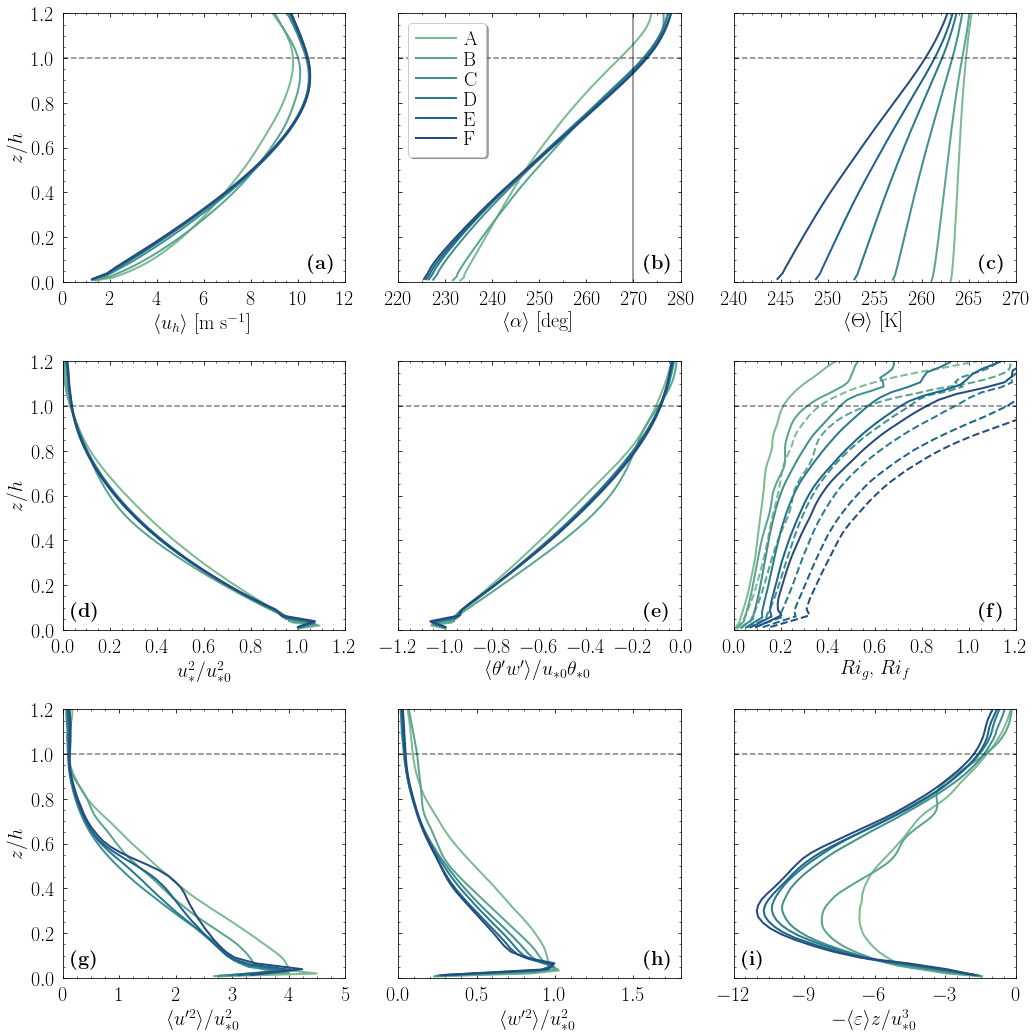

In [4]:
# Figure 1: 9-panel everything
# (a) <u>, <v>; (b) wdir; (c) <\Theta>;
# (d) <u'w'>, <v'w'>; (e) <\theta'w'>; (f) <u'^2>;
# (g) <v'^2>; (h) <w'^2>; (i) <\theta'^2>
fig1, ax1 = plt.subplots(nrows=3, ncols=3, sharey=True, figsize=(14.8, 14.8))
for i, s in enumerate(sall):
    # now plot
    # row 1
    # (a) <u>, <v>
    # ax1[0,0].plot(s.u_mean, s.z/s.h, ls="-", c=colors[i], lw=2)
    # ax1[0,0].plot(s.v_mean, s.z/s.h, ls=":", c=colors[i], lw=2)
    ax1[0,0].plot(s.uh, s.z/s.h, ls="-", c=colors[i], lw=2)
    # (b) wind direction
    ax1[0,1].plot(s.wdir, s.z/s.h, ls="-", c=colors[i], lw=2, 
                  label=s.label2)
    # (c) <\Theta>
    ax1[0,2].plot(s.theta_mean, s.z/s.h, ls="-", c=colors[i], lw=2)
    # row 2
    # (d) ustar^2
    # ax1[1,0].plot(s.uw_cov_tot/s.ustar0/s.ustar0, s.z/s.h, ls="-", c=colors[i], lw=2)
    # ax1[1,0].plot(s.vw_cov_tot/s.ustar0/s.ustar0, s.z/s.h, ls=":", c=colors[i], lw=2)
    ax1[1,0].plot(s.ustar2/s.ustar0/s.ustar0, s.z/s.h, ls="-", c=colors[i], lw=2)
    # (e) <\theta'w'>
    ax1[1,1].plot(s.tw_cov_tot/s.ustar0/s.tstar0, s.z/s.h, ls="-", c=colors[i], lw=2)
    # (f) Rig, Rif
    ax1[1,2].plot(s.Rig, s.z/s.h, ls="-", c=colors[i], lw=2)
    ax1[1,2].plot(s.Rif, s.z/s.h, ls="--", c=colors[i], lw=2)
    # row 3
    # (g) <u'^2> ROTATED
    ax1[2,0].plot(s.u_var_rot/s.ustar0/s.ustar0, s.z/s.h, ls="-", c=colors[i], lw=2)
    # (h) <w'^2>
    ax1[2,1].plot(s.w_var/s.ustar0/s.ustar0, s.z/s.h, ls="-", c=colors[i], lw=2)
    # (i) <\epsilon>
    ax1[2,2].plot(s.dissip_mean*s.z/s.ustar0/s.ustar0/s.ustar0, s.z/s.h, 
                  ls="-", c=colors[i], lw=2)
# clean up
# (a)
ax1[0,0].set_xlabel("$\\langle u_h \\rangle$ [m s$^{-1}$]")
ax1[0,0].set_ylabel("$z/h$")
ax1[0,0].set_xlim([0, 12.])
ax1[0,0].xaxis.set_major_locator(MultipleLocator(2))
ax1[0,0].xaxis.set_minor_locator(MultipleLocator(0.5))
ax1[0,0].set_ylim([0, 1.2])
ax1[0,0].yaxis.set_major_locator(MultipleLocator(0.2))
ax1[0,0].yaxis.set_minor_locator(MultipleLocator(0.05))
# ax1[0,0].axvline(0., c="k", alpha=0.5)
ax1[0,0].text(0.87,0.05,r'\textbf{(a)}',fontsize=20,bbox=props, 
              transform=ax1[0,0].transAxes)
# (b)
ax1[0,1].set_xlabel("$\\langle \\alpha \\rangle$ [deg]")
ax1[0,1].set_xlim([220, 280.])
ax1[0,1].xaxis.set_major_locator(MultipleLocator(10))
ax1[0,1].xaxis.set_minor_locator(MultipleLocator(5))
ax1[0,1].axvline(270., c="k", alpha=0.5)
ax1[0,1].text(0.87,0.05,r'\textbf{(b)}',fontsize=20,bbox=props, 
              transform=ax1[0,1].transAxes)
ax1[0,1].legend(loc="upper left", labelspacing=0.10, 
                handletextpad=0.4, shadow=True)
# (c)
ax1[0,2].set_xlabel("$\\langle \\Theta \\rangle$ [K]")
ax1[0,2].set_xlim([240, 270.])
ax1[0,2].xaxis.set_major_locator(MultipleLocator(5))
ax1[0,2].xaxis.set_minor_locator(MultipleLocator(1))
ax1[0,2].text(0.87,0.05,r'\textbf{(c)}',fontsize=20,bbox=props, 
              transform=ax1[0,2].transAxes)
# (d)
ax1[1,0].set_xlabel("$u_*^2 / u_{*0}^2$")
ax1[1,0].set_ylabel("$z/h$")
ax1[1,0].set_xlim([0, 1.2])
ax1[1,0].xaxis.set_major_locator(MultipleLocator(0.2))
ax1[1,0].xaxis.set_minor_locator(MultipleLocator(0.05))
ax1[1,0].axvline(0., c="k", alpha=0.5)
ax1[1,0].text(0.03,0.05,r'\textbf{(d)}',fontsize=20,bbox=props, 
              transform=ax1[1,0].transAxes)
# (e)
ax1[1,1].set_xlabel("$\\langle \\theta'w' \\rangle / u_{*0} \\theta_{*0}$")
ax1[1,1].set_xlim([-1.2, 0])
ax1[1,1].xaxis.set_major_locator(MultipleLocator(0.2))
ax1[1,1].xaxis.set_minor_locator(MultipleLocator(0.05))
# ax1[1,1].axvline(0., c="k", alpha=0.5)
ax1[1,1].text(0.87,0.05,r'\textbf{(e)}',fontsize=20,bbox=props, 
              transform=ax1[1,1].transAxes)
# (f)
ax1[1,2].set_xlabel("$Ri_g$, $Ri_f$")
ax1[1,2].set_xlim([0, 1.2])
ax1[1,2].xaxis.set_major_locator(MultipleLocator(0.2))
ax1[1,2].xaxis.set_minor_locator(MultipleLocator(0.05))
# ax1[1,2].axvline(0., c="k", alpha=0.5)
ax1[1,2].text(0.87,0.05,r'\textbf{(f)}',fontsize=20,bbox=props, 
              transform=ax1[1,2].transAxes)
# (g)
ax1[2,0].set_xlabel("$\\langle u'^2 \\rangle / u_{*0}^2$")
ax1[2,0].set_ylabel("$z/h$")
ax1[2,0].set_xlim([0, 5])
ax1[2,0].xaxis.set_major_locator(MultipleLocator(1))
ax1[2,0].xaxis.set_minor_locator(MultipleLocator(0.25))
# ax1[2,0].axvline(0., c="k", alpha=0.5)
ax1[2,0].text(0.03,0.05,r'\textbf{(g)}',fontsize=20,bbox=props, 
              transform=ax1[2,0].transAxes)
# (h)
ax1[2,1].set_xlabel("$\\langle w'^2 \\rangle / u_{*0}^2$")
ax1[2,1].set_xlim([0, 1.8])
ax1[2,1].xaxis.set_major_locator(MultipleLocator(0.5))
ax1[2,1].xaxis.set_minor_locator(MultipleLocator(0.1))
# ax1[2,1].axvline(0., c="k", alpha=0.5)
ax1[2,1].text(0.87,0.05,r'\textbf{(h)}',fontsize=20,bbox=props, 
              transform=ax1[2,1].transAxes)
# (i)
ax1[2,2].set_xlabel("$-\\langle \\varepsilon \\rangle z/u_{*0}^3$ ")
ax1[2,2].set_xlim([-12, 0])
ax1[2,2].xaxis.set_major_locator(MultipleLocator(3))
ax1[2,2].xaxis.set_minor_locator(MultipleLocator(0.5))
# ax1[2,2].axvline(0., c="k", alpha=0.5)
ax1[2,2].text(0.03,0.05,r'\textbf{(i)}',fontsize=20,bbox=props, 
              transform=ax1[2,2].transAxes)
# add horizontal line at z/h = 1 for all
# tick lines inside plot
for iax in ax1.flatten():
    iax.axhline(1.0, c="k", alpha=0.5, ls="--")
    iax.tick_params(which="both", direction="in", top=True, right=True, pad=8)
# # save and close
fig1.tight_layout()
# fig1.savefig(f"{fdir_save}mean_prof_3x3_v3.pdf", format="pdf")
# plt.close(fig1)

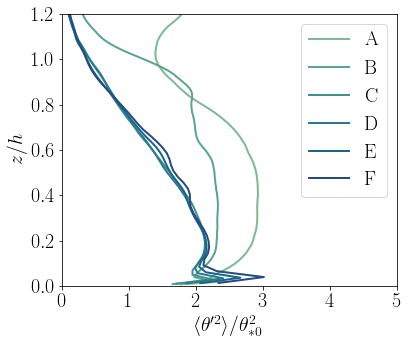

In [5]:
# theta variance
fig1a, ax1a = plt.subplots(1, figsize=(6, 5))
for i, s in enumerate(sall):
    ax1a.plot(s.theta_var/s.tstar0/s.tstar0, s.z/s.h, ls="-", c=colors[i], lw=2, label=s.label2)
ax1a.set_ylim([0, 1.2])
ax1a.set_ylabel("$z/h$")
ax1a.set_xlim([0, 5])
ax1a.set_xlabel("$\\langle \\theta'^2 \\rangle / \\theta_{*0}^2$")
ax1a.legend()

# Figure 1 with 2 hr averages

In [6]:
sall2 = []
# loop over sims and load stats data
for sim in sims:
    dnc = f"/home/bgreene/simulations/{sim}_192/output/netcdf/"
    dnc_all.append(dnc)
    # load stats file
    s = load_stats(dnc+"average_statistics_2hr.nc")
    s.attrs["label2"] = labels[s.stability]
    sall2.append(s)
    break

Reading file: /home/bgreene/simulations/cr0.25_u08_192/output/netcdf/average_statistics_2hr.nc


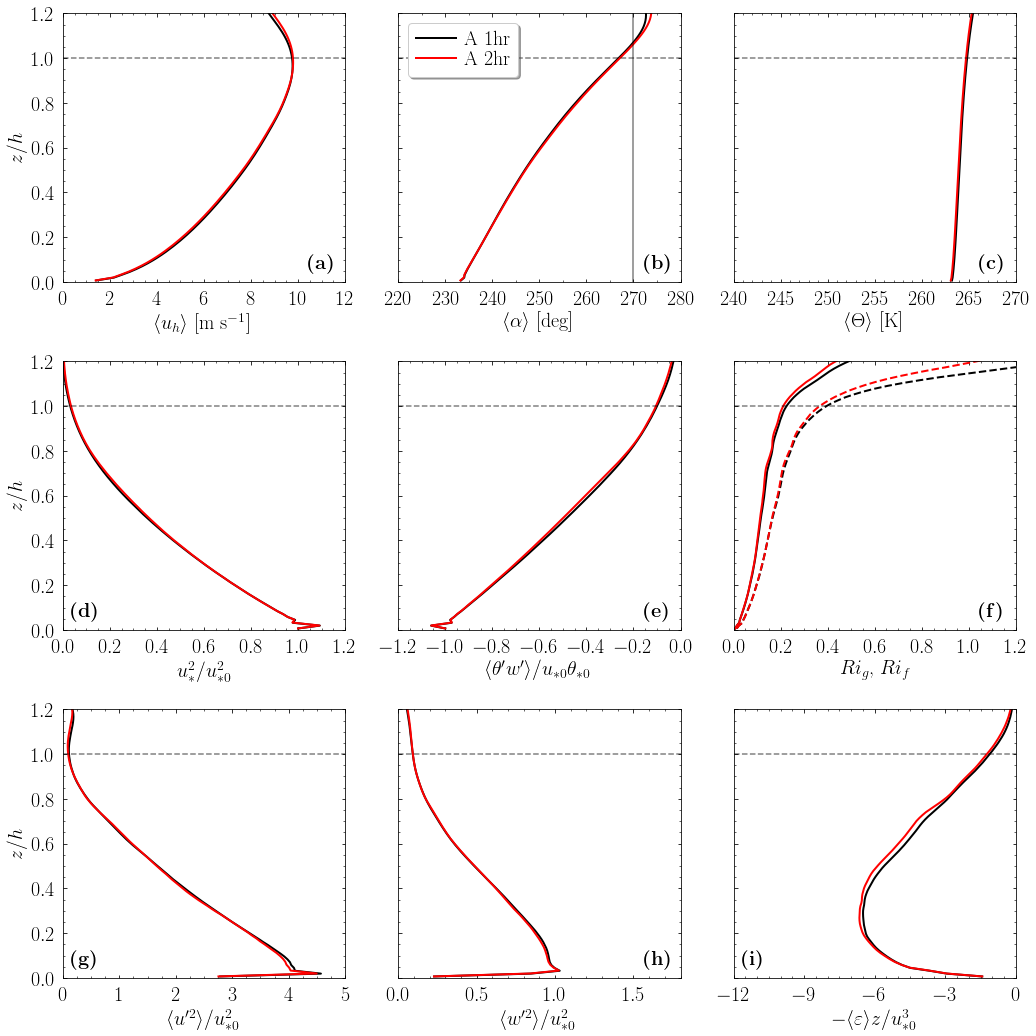

In [11]:
# Figure 1: 9-panel everything - compare 1 and 2 hr averages
# (a) <u>, <v>; (b) wdir; (c) <\Theta>;
# (d) <u'w'>, <v'w'>; (e) <\theta'w'>; (f) <u'^2>;
# (g) <v'^2>; (h) <w'^2>; (i) <\theta'^2>
fig1, ax1 = plt.subplots(nrows=3, ncols=3, sharey=True, figsize=(14.8, 14.8))
c2h = ["k", "r"]
for i, s in enumerate(sall2+[sall[0]]):
    # now plot
    # row 1
    # (a) <u>, <v>
    # ax1[0,0].plot(s.u_mean, s.z/s.h, ls="-", c=colors[i], lw=2)
    # ax1[0,0].plot(s.v_mean, s.z/s.h, ls=":", c=colors[i], lw=2)
    ax1[0,0].plot(s.uh, s.z/s.h, ls="-", c=c2h[i], lw=2)
    # (b) wind direction
    ax1[0,1].plot(s.wdir, s.z/s.h, ls="-", c=c2h[i], lw=2, 
                  label=f"A {list('12')[i]}hr")
    # (c) <\Theta>
    ax1[0,2].plot(s.theta_mean, s.z/s.h, ls="-", c=c2h[i], lw=2)
    # row 2
    # (d) ustar^2
    # ax1[1,0].plot(s.uw_cov_tot/s.ustar0/s.ustar0, s.z/s.h, ls="-", c=colors[i], lw=2)
    # ax1[1,0].plot(s.vw_cov_tot/s.ustar0/s.ustar0, s.z/s.h, ls=":", c=colors[i], lw=2)
    ax1[1,0].plot(s.ustar2/s.ustar0/s.ustar0, s.z/s.h, ls="-", c=c2h[i], lw=2)
    # (e) <\theta'w'>
    ax1[1,1].plot(s.tw_cov_tot/s.ustar0/s.tstar0, s.z/s.h, ls="-", c=c2h[i], lw=2)
    # (f) Rig, Rif
    ax1[1,2].plot(s.Rig, s.z/s.h, ls="-", c=c2h[i], lw=2)
    ax1[1,2].plot(s.Rif, s.z/s.h, ls="--", c=c2h[i], lw=2)
    # row 3
    # (g) <u'^2> ROTATED
    ax1[2,0].plot(s.u_var_rot/s.ustar0/s.ustar0, s.z/s.h, ls="-", c=c2h[i], lw=2)
    # (h) <w'^2>
    ax1[2,1].plot(s.w_var/s.ustar0/s.ustar0, s.z/s.h, ls="-", c=c2h[i], lw=2)
    # (i) <\epsilon>
    ax1[2,2].plot(s.dissip_mean*s.z/s.ustar0/s.ustar0/s.ustar0, s.z/s.h, 
                  ls="-", c=c2h[i], lw=2)
# clean up
# (a)
ax1[0,0].set_xlabel("$\\langle u_h \\rangle$ [m s$^{-1}$]")
ax1[0,0].set_ylabel("$z/h$")
ax1[0,0].set_xlim([0, 12.])
ax1[0,0].xaxis.set_major_locator(MultipleLocator(2))
ax1[0,0].xaxis.set_minor_locator(MultipleLocator(0.5))
ax1[0,0].set_ylim([0, 1.2])
ax1[0,0].yaxis.set_major_locator(MultipleLocator(0.2))
ax1[0,0].yaxis.set_minor_locator(MultipleLocator(0.05))
# ax1[0,0].axvline(0., c="k", alpha=0.5)
ax1[0,0].text(0.87,0.05,r'\textbf{(a)}',fontsize=20,bbox=props, 
              transform=ax1[0,0].transAxes)
# (b)
ax1[0,1].set_xlabel("$\\langle \\alpha \\rangle$ [deg]")
ax1[0,1].set_xlim([220, 280.])
ax1[0,1].xaxis.set_major_locator(MultipleLocator(10))
ax1[0,1].xaxis.set_minor_locator(MultipleLocator(5))
ax1[0,1].axvline(270., c="k", alpha=0.5)
ax1[0,1].text(0.87,0.05,r'\textbf{(b)}',fontsize=20,bbox=props, 
              transform=ax1[0,1].transAxes)
ax1[0,1].legend(loc="upper left", labelspacing=0.10, 
                handletextpad=0.4, shadow=True)
# (c)
ax1[0,2].set_xlabel("$\\langle \\Theta \\rangle$ [K]")
ax1[0,2].set_xlim([240, 270.])
ax1[0,2].xaxis.set_major_locator(MultipleLocator(5))
ax1[0,2].xaxis.set_minor_locator(MultipleLocator(1))
ax1[0,2].text(0.87,0.05,r'\textbf{(c)}',fontsize=20,bbox=props, 
              transform=ax1[0,2].transAxes)
# (d)
ax1[1,0].set_xlabel("$u_*^2 / u_{*0}^2$")
ax1[1,0].set_ylabel("$z/h$")
ax1[1,0].set_xlim([0, 1.2])
ax1[1,0].xaxis.set_major_locator(MultipleLocator(0.2))
ax1[1,0].xaxis.set_minor_locator(MultipleLocator(0.05))
ax1[1,0].axvline(0., c="k", alpha=0.5)
ax1[1,0].text(0.03,0.05,r'\textbf{(d)}',fontsize=20,bbox=props, 
              transform=ax1[1,0].transAxes)
# (e)
ax1[1,1].set_xlabel("$\\langle \\theta'w' \\rangle / u_{*0} \\theta_{*0}$")
ax1[1,1].set_xlim([-1.2, 0])
ax1[1,1].xaxis.set_major_locator(MultipleLocator(0.2))
ax1[1,1].xaxis.set_minor_locator(MultipleLocator(0.05))
# ax1[1,1].axvline(0., c="k", alpha=0.5)
ax1[1,1].text(0.87,0.05,r'\textbf{(e)}',fontsize=20,bbox=props, 
              transform=ax1[1,1].transAxes)
# (f)
ax1[1,2].set_xlabel("$Ri_g$, $Ri_f$")
ax1[1,2].set_xlim([0, 1.2])
ax1[1,2].xaxis.set_major_locator(MultipleLocator(0.2))
ax1[1,2].xaxis.set_minor_locator(MultipleLocator(0.05))
# ax1[1,2].axvline(0., c="k", alpha=0.5)
ax1[1,2].text(0.87,0.05,r'\textbf{(f)}',fontsize=20,bbox=props, 
              transform=ax1[1,2].transAxes)
# (g)
ax1[2,0].set_xlabel("$\\langle u'^2 \\rangle / u_{*0}^2$")
ax1[2,0].set_ylabel("$z/h$")
ax1[2,0].set_xlim([0, 5])
ax1[2,0].xaxis.set_major_locator(MultipleLocator(1))
ax1[2,0].xaxis.set_minor_locator(MultipleLocator(0.25))
# ax1[2,0].axvline(0., c="k", alpha=0.5)
ax1[2,0].text(0.03,0.05,r'\textbf{(g)}',fontsize=20,bbox=props, 
              transform=ax1[2,0].transAxes)
# (h)
ax1[2,1].set_xlabel("$\\langle w'^2 \\rangle / u_{*0}^2$")
ax1[2,1].set_xlim([0, 1.8])
ax1[2,1].xaxis.set_major_locator(MultipleLocator(0.5))
ax1[2,1].xaxis.set_minor_locator(MultipleLocator(0.1))
# ax1[2,1].axvline(0., c="k", alpha=0.5)
ax1[2,1].text(0.87,0.05,r'\textbf{(h)}',fontsize=20,bbox=props, 
              transform=ax1[2,1].transAxes)
# (i)
ax1[2,2].set_xlabel("$-\\langle \\varepsilon \\rangle z/u_{*0}^3$ ")
ax1[2,2].set_xlim([-12, 0])
ax1[2,2].xaxis.set_major_locator(MultipleLocator(3))
ax1[2,2].xaxis.set_minor_locator(MultipleLocator(0.5))
# ax1[2,2].axvline(0., c="k", alpha=0.5)
ax1[2,2].text(0.03,0.05,r'\textbf{(i)}',fontsize=20,bbox=props, 
              transform=ax1[2,2].transAxes)
# add horizontal line at z/h = 1 for all
# tick lines inside plot
for iax in ax1.flatten():
    iax.axhline(1.0, c="k", alpha=0.5, ls="--")
    iax.tick_params(which="both", direction="in", top=True, right=True, pad=8)
# # save and close
fig1.tight_layout()
fig1.savefig("/home/bgreene/SBL_LES/figures/mean_profiles/mean_prof_1-2h_comp.pdf", format="pdf")
# plt.close(fig1)

# Others

### Figure 1: $u$, $v$, $u_h$, $\theta$

No handles with labels found to put in legend.


Text(0.5, 0, '$\\langle \\theta \\rangle$ [K]')

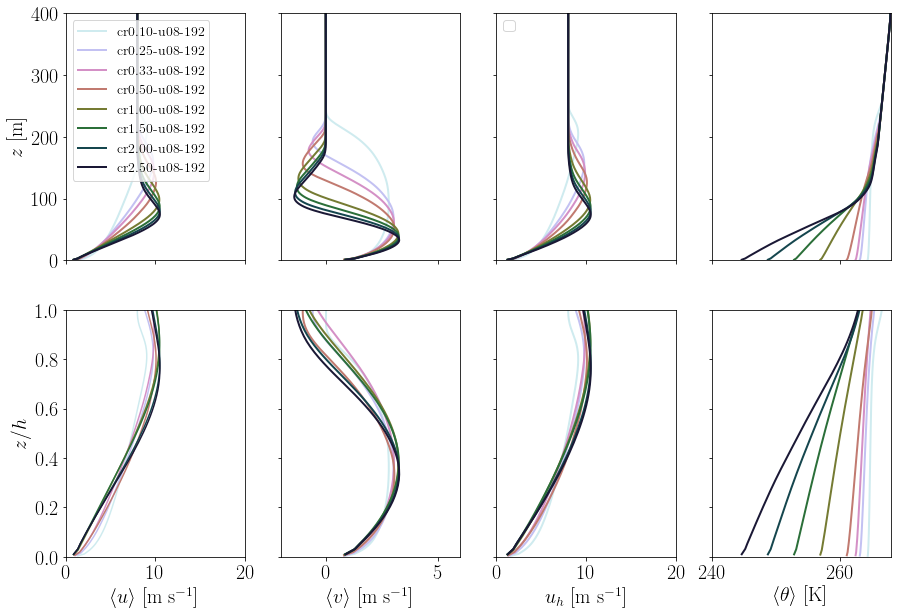

In [4]:
# figure 1: u, v, theta versus z - NOT normalized; u, v, theta vs z/h
fig1, ax1 = plt.subplots(nrows=2, ncols=4, sharey="row", sharex="col", figsize=(14.8, 10))
# loop over sims
for js, s in enumerate(sall):
    # row 1: dimensional
    # a) u
    ax1[0,0].plot(s.u_mean, s.z, ls="-", lw=2, c=cmap[js], 
                label="-".join(s.stability.split("_")))
    # b) v
    ax1[0,1].plot(s.v_mean, s.z, ls="-", lw=2, c=cmap[js])
    # c) ws
    ax1[0,2].plot(s.uh, s.z, ls="-", lw=2, c=cmap[js])
    # d) theta
    ax1[0,3].plot(s.theta_mean, s.z, ls="-", lw=2, c=cmap[js],
                label=f"$h/L = {{{s.hL.values:3.2f}}}$")
    # row 2: normalized z/h
    # e) u
    ax1[1,0].plot(s.u_mean, s.z/s.he, ls="-", c=cmap[js])
    # f) v
    ax1[1,1].plot(s.v_mean, s.z/s.he, ls="-", lw=2, c=cmap[js])
    # g) uh
    ax1[1,2].plot(s.uh, s.z/s.he, ls="-", lw=2, c=cmap[js])
    # h) theta
    ax1[1,3].plot(s.theta_mean, s.z/s.he, ls="-", lw=2, c=cmap[js])    

# clean up
ax1[0,0].legend(fontsize=14, loc="upper left")
ax1[0,0].set_ylim([0, 400])
ax1[0,0].set_ylabel("$z$ [m]")

ax1[0,2].legend(fontsize=14, loc="upper left")

ax1[1,0].set_ylim([0, 1])
ax1[1,0].set_ylabel("$z/h$")
ax1[1,0].set_xlim([0, 20])
ax1[1,0].set_xlabel("$\\langle u \\rangle$ [m s$^{-1}$]")

ax1[1,1].set_xlim([-2, 6])
ax1[1,1].set_xlabel("$\\langle v \\rangle$ [m s$^{-1}$]")

ax1[1,2].set_xlim([0, 20])
ax1[1,2].set_xlabel("$u_h$ [m s$^{-1}$]")

ax1[1,3].set_xlim([240, 268])
ax1[1,3].set_xlabel("$\\langle \\theta \\rangle$ [K]")

### Figure 2: Fluxes

Text(0.5, 0, "$\\langle \\theta' w' \\rangle / u_{*0} \\theta_{*0}$")

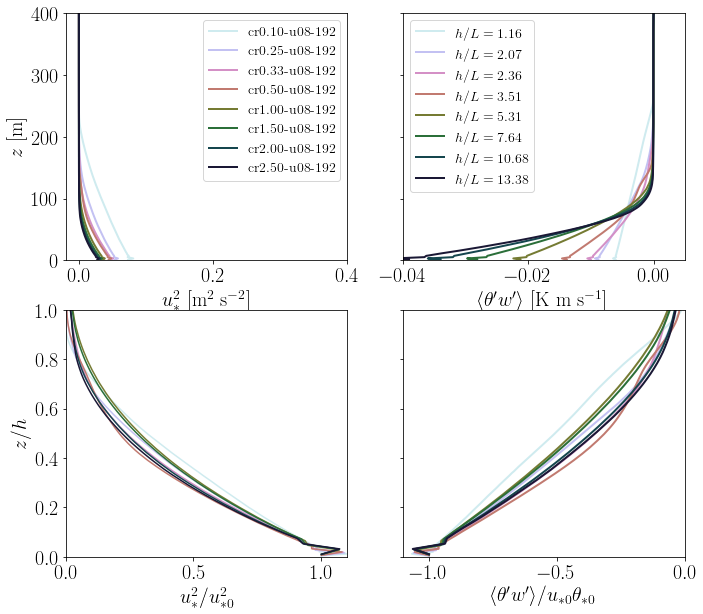

In [5]:
# figure 2: ustar^2, theta'w'
fig2, ax2 = plt.subplots(nrows=2, ncols=2, sharey="row", figsize=(11.1, 10))
# loop over sims
for js, s in enumerate(sall):
    # row 1: dimensional
    # a) ustar^2
    ax2[0,0].plot(s.ustar2, s.z, ls="-", lw=2, c=cmap[js], 
                  label="-".join(s.stability.split("_")))
    # b) theta'w'
    ax2[0,1].plot(s.tw_cov_tot, s.z, ls="-", lw=2, c=cmap[js],
                  label=f"$h/L = {{{s.hL.values:3.2f}}}$")
    # row 2: normalized z/h, u*, theta*
    # d) ustar2 / ustar0^2
    ax2[1,0].plot(s.ustar2/s.ustar0/s.ustar0, s.z/s.he, ls="-", c=cmap[js])
    # e) v/ustar
    ax2[1,1].plot(s.tw_cov_tot/s.ustar0/s.tstar0, s.z/s.he, ls="-", lw=2, c=cmap[js])

# labels
ax2[0,0].legend(fontsize=14)
ax2[0,0].set_ylim([0, 400])
ax2[0,0].set_ylabel("$z$ [m]")
ax2[0,0].set_xlim([-0.02, 0.4])
ax2[0,0].set_xlabel("$u_{*}^2$ [m$^2$ s$^{-2}$]")

ax2[0,1].legend(fontsize=14)
ax2[0,1].set_xlim([-0.04, 0.005])
ax2[0,1].set_xlabel("$\\langle \\theta' w' \\rangle$ [K m s$^{-1}$]")

ax2[1,0].set_ylim([0, 1])
ax2[1,0].set_ylabel("$z/h$")
ax2[1,0].set_xlim([0, 1.1])
ax2[1,0].set_xlabel("$u_{*}^2 / u_{*0}^2$")

ax2[1,1].set_xlim([-1.1, 0])
ax2[1,1].set_xlabel("$\\langle \\theta' w' \\rangle / u_{*0} \\theta_{*0}$")

### Figure 3: variances urot, vrot, w, theta

Text(0.5, 0, "$\\langle \\theta'\\theta' \\rangle / \\theta_{*0}^2$")

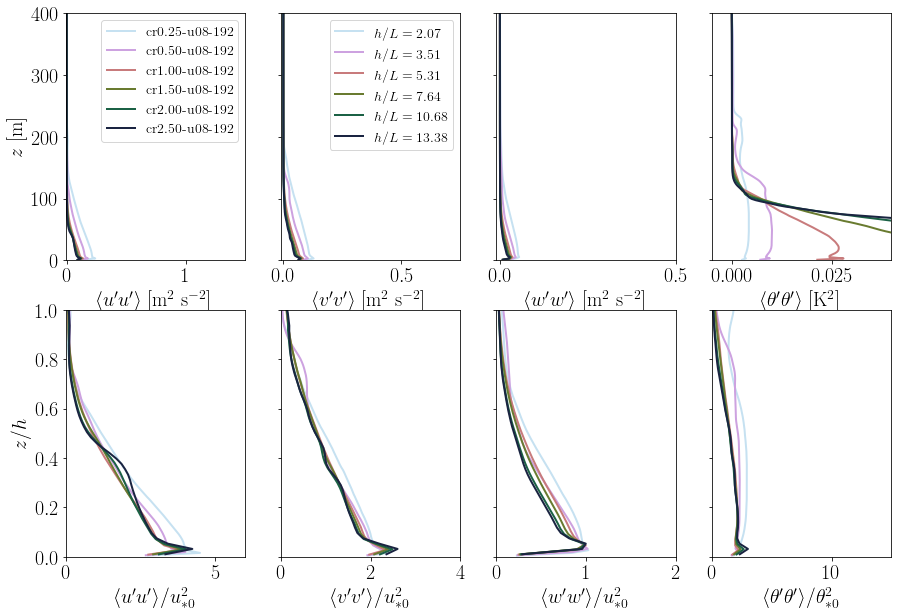

In [7]:
# figure 3: u'u', v'v', w'w', t't'
fig3, ax3 = plt.subplots(nrows=2, ncols=4, sharey="row", figsize=(14.8, 10))
# loop over sims
for js, s in enumerate(sall):
    # row 1: dimensional
    # a) u'u'
    ax3[0,0].plot(s.u_var_rot, s.z, ls="-", lw=2, c=cmap[js], 
                  label="-".join(s.stability.split("_")))
    # b) v'v'
    ax3[0,1].plot(s.v_var_rot, s.z, ls="-", lw=2, c=cmap[js],
                  label=f"$h/L = {{{s.hL.values:3.2f}}}$")
    # c) w'w'
    ax3[0,2].plot(s.w_var, s.z, ls="-", lw=2, c=cmap[js])
    # d) t't'
    ax3[0,3].plot(s.theta_var, s.z, ls="-", lw=2, c=cmap[js])
    # row 2: normalized z/h, u*, theta*
    # e) u'u'/ustar2
    ax3[1,0].plot(s.u_var_rot/s.ustar0/s.ustar0, s.z/s.he, ls="-", lw=2, c=cmap[js])
    # f) v'v'/ustar2
    ax3[1,1].plot(s.v_var_rot/s.ustar0/s.ustar0, s.z/s.he, ls="-", lw=2, c=cmap[js])
    # g) w'w'/ustar2
    ax3[1,2].plot(s.w_var/s.ustar0/s.ustar0, s.z/s.he, ls="-", lw=2, c=cmap[js])
    # h) t't'/tstar2
    ax3[1,3].plot(s.theta_var/s.tstar0/s.tstar0, s.z/s.he, ls="-", lw=2, c=cmap[js])

# labels
ax3[0,0].legend(fontsize=14)
ax3[0,0].set_ylim([0, 400])
ax3[0,0].set_ylabel("$z$ [m]")
ax3[0,0].set_xlim([-0.01, 1.5])
ax3[0,0].set_xlabel("$\\langle u'u' \\rangle$ [m$^2$ s$^{-2}$]")

ax3[0,1].legend(fontsize=14)
ax3[0,1].set_xlim([-0.01, 0.75])
ax3[0,1].set_xlabel("$\\langle v'v' \\rangle$ [m$^2$ s$^{-2}$]")

ax3[0,2].set_xlim([-0.01, 0.5])
ax3[0,2].set_xlabel("$\\langle w'w' \\rangle$ [m$^2$ s$^{-2}$]")

ax3[0,3].set_xlim([-0.005, 0.04])
ax3[0,3].set_xlabel("$\\langle \\theta'\\theta' \\rangle$ [K$^2$]")

ax3[1,0].set_ylim([0, 1])
ax3[1,0].set_ylabel("$z/h$")
ax3[1,0].set_xlim([0, 6])
ax3[1,0].set_xlabel("$\\langle u'u' \\rangle / u_{*0}^2$")

ax3[1,1].set_xlim([0, 4])
ax3[1,1].set_xlabel("$\\langle v'v' \\rangle / u_{*0}^2$")

ax3[1,2].set_xlim([0, 2])
ax3[1,2].set_xlabel("$\\langle w'w' \\rangle / u_{*0}^2$")

ax3[1,3].set_xlim([0, 15])
ax3[1,3].set_xlabel("$\\langle \\theta'\\theta' \\rangle / \\theta_{*0}^2$")

### Figure 4: Richardson numbers and Prandtl

Text(0.5, 0, '$Pr_t = Ri_g/ Ri_f$')

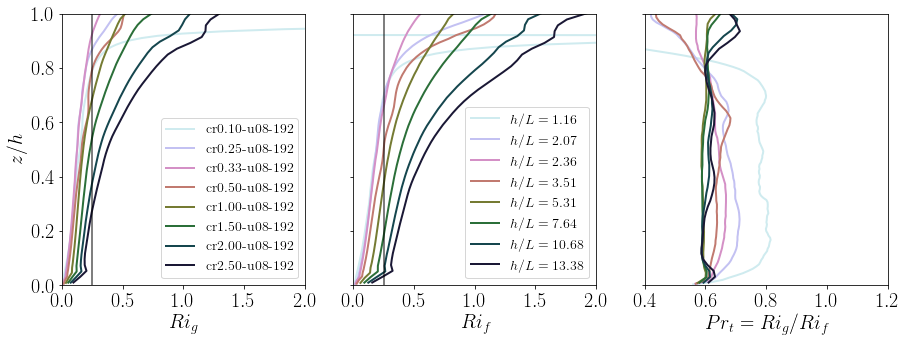

In [7]:
# figure 4: Ri_g, Ri_f, Pr_t
fig3, ax3 = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(14.8, 5))
# loop over sims
for js, s in enumerate(sall):
    # a)Ri_g
    ax3[0].plot(s.Rig, s.z/s.he, ls="-", lw=2, c=cmap[js], 
                label="-".join(s.stability.split("_")))
    # b) v'v'
    ax3[1].plot(s.Rif, s.z/s.he, ls="-", lw=2, c=cmap[js],
                label=f"$h/L = {{{s.hL.values:3.2f}}}$")
    # c) w'w'
    ax3[2].plot(s.Rig/s.Rif, s.z/s.he, ls="-", lw=2, c=cmap[js])

# labels
ax3[0].legend(fontsize=14)
ax3[0].set_ylim([0, 1])
ax3[0].set_ylabel("$z/h$")
ax3[0].set_xlim([0, 2])
ax3[0].set_xlabel("$Ri_g$")
ax3[0].axvline(0.25, c="k", lw=2, alpha=0.5)

ax3[1].legend(fontsize=14)
ax3[1].set_xlim([0, 2])
ax3[1].set_xlabel("$Ri_f$")
ax3[1].axvline(0.25, c="k", lw=2, alpha=0.5)

ax3[2].set_xlim([0.4, 1.2])
ax3[2].set_xlabel("$Pr_t = Ri_g/ Ri_f$")

In [9]:
print("zj", "h", "zj/h")
for s in sall:
    print(f"{s.zj.values:3.1f}", f"{s.he.values:3.1f}", f"{(s.zj/s.he).values:4.3f}")

zj h zj/h
204.2 256.5 0.796
155.4 207.3 0.750
140.9 196.9 0.716
126.4 188.6 0.670
